# Approximating Arbitrary Functions with PyTorch

All neural networks are in essense, trainable output approximation function. 

Every input passed through a neural network will have some amount of error associated to the output. 

Training is done by passing an input to the neural network to get the error, and minimizing the error, by tweaking the internal parameters.

This can be done because every computation done in a neural network is fully differentiable, so you can calculate how much the error will change if you change any parameter.

In this notebook, we will construct a simple function that takes in a number of inputs, and gives back a single number from it. We will be using a neural network to approximate that function.

This kind of task is called regression.

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from ipywidgets import interact

# Defining our data

We will construct a function defined by $f(x_0,x_1,x_2)=cos(x_0)sin(x_1)-x_1 x_2 $.

In [4]:
#input shape : (n,3), output shape: (n,1)
def value(x):
    return torch.unsqueeze(torch.cos(x[:,0])*torch.sin(x[:,1])-x[:,1]*x[:,2],1)

#output x: tensor with shape (n,3) and uniform from -1 to 1
def data(n):
    x=torch.rand((n,3))*2-1
    y=value(x)

    return x,y


# Defining our Model
The neural network will take a tensor with 3 dimension and outputs a tensor with 1 dimension. 

In [5]:
class ReZeroShortcut(nn.Module):
    def __init__(self, alpha=0.0):
        super(ReZeroShortcut, self).__init__()
        self.alpha = nn.parameter.Parameter(torch.ones(1) * alpha)

    def forward(self, shortcut, x):
        return shortcut + self.alpha * x

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(3,10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 1)
        
        self.elu = nn.ELU(1)

    def forward(self,x):
        x = self.fc1(x)
        x = self.elu(x)
        
        y = self.fc2(x)
        y = self.elu(y)
        
        x = ReZeroShortcut()(x,y)
        
        y = self.fc3(x)
        y = self.elu(y)
        
        x = ReZeroShortcut()(x,y)
        
        x = self.fc4(x)
        
        return x

# Visualization

In [6]:
# Plot the loss function given a list
def plot(data):
    display.clear_output(wait=True)
    plt.clf()
    
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.grid(True)
    
    plt.plot(data)
    plt.legend(['Loss'], loc='lower left')
    
    
    display.display(plt.gcf())

# Given 3 numbers and one axis, plots the model and the function when you move along one axis but hold the rest in place
def manipulate(x0,x1,x2,d):
    ranges = torch.arange(-1,1.2,0.2)
    
    x = torch.cat([torch.full( (len(ranges),1), i ) for i in [x0,x1,x2]],1)
    
    x[:,d] = ranges
    x_values = value(x)
    values = model(x).detach()

    plt.plot(ranges,values)
    plt.plot(ranges,x_values)
    plt.legend(['model','data'],loc='lower right')
    plt.show()
    
    mean_squared_error = torch.mean((values-x_values)**2)
    
    print(f"mean_squared_error = {mean_squared_error}")

# Train loop

In PyTorch, the basic train loop consists of 


1.   Loading training data
2.   Initilize gradients for the model
3.   Forward pass until the loss
4.   Backpropagate the loss
5.   Do the optimization step

In a regression problem, the cost function to use is the mean squared error loss, given by $\frac{1}{n}\sum_{i=1}^{n}(y_{i} - x_{i})^2$.

This assigns a larger loss to datapoints that are more off, compared to similar loss functions like l1 norm, which are means of absolute differences.

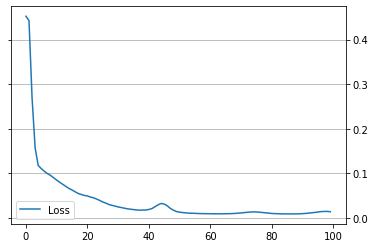

0.4522595703601837
0.44257813692092896
0.269067645072937
0.1567630022764206
0.11739339679479599
0.11032279580831528
0.10445042699575424
0.09916900098323822
0.0951765701174736
0.08996274322271347
0.08463788777589798
0.07974520325660706
0.07510354369878769
0.07039827853441238
0.06596757471561432
0.06241627782583237
0.05844450742006302
0.05468733236193657
0.05239207670092583
0.05021088197827339
0.04909347742795944
0.04659149795770645
0.044825389981269836
0.04210987314581871
0.0390547513961792
0.035486526787281036
0.033084627240896225
0.029867297038435936
0.028049299493432045
0.026307765394449234
0.024433022364974022
0.023124204948544502
0.021603837609291077
0.020255552604794502
0.019306963309645653
0.018529966473579407
0.017623424530029297
0.017179492861032486
0.01736547239124775
0.017502302303910255
0.01878616027534008
0.020767154172062874
0.025005454197525978
0.029241224750876427
0.032195936888456345
0.030831508338451385
0.02685556933283806
0.0209877397865057
0.017115596681833267
0.0140

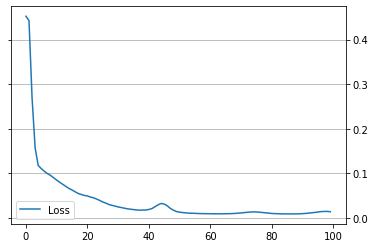

In [13]:
model=Model()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

losses=[]

for i in range(100):
    x,y=data(100000)
        
    optimizer.zero_grad()

    loss = nn.MSELoss()(model(x),y)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())
    
    plot(losses)
    for i in losses:
        print(i)
    

Given 3 numbers and one axis, plots the model and the function when you move along one axis but hold the rest in place.

In [10]:
%matplotlib inline
interact(manipulate,x0=(-1,1,0.1),x1=(-1,1,0.1),x2=(-1,1,0.1),d=(0,2))

interactive(children=(FloatSlider(value=0.0, description='x0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.manipulate(x0, x1, x2, d)>